#### This notebook analyses how the 1D model's responses change as a function of the paramater choices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from scipy.optimize import curve_fit

In [5]:
# Constants, data, parameters...

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3645
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC    


### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T

# a) Changing kappa

In [6]:
### Run experiment

years = 100
days = dt / 86400
N = int(years * 360 / days)
M = int(z_b / dz)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
mu = 1/(10 * 365 * 86400)

kappas = np.array([1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5])

Q_cont = np.append(0, np.zeros(int(years * 360 / days)))
T0_cont = np.append(0, np.zeros(int(years * 360 / days)))
Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

control_kappa = np.zeros(shape = (M, N+1, kappas.shape[0]))
cool_kappa = np.zeros(shape = (M, N+1, kappas.shape[0]))
warm_kappa = np.zeros(shape = (M, N+1, kappas.shape[0]))

for k in range(len(kappas)):
    control_kappa[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, T_i, Q_cont, T0_cont, years)
    cool_kappa[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, T_i, - Q, - T0, years)
    warm_kappa[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, T_i, Q, T0, years)

I need a better way to plot all this. Need to think about it!
CONCLUSION: The diffusivity is important for setting both the size of the average temperature response as well as how nonlinear it is. The difference between responses is smaller by the end of the simulation for higher diffusivities (i.e. less nonlinear), which makes sense as the warming information being integrated into the water column is completely dependent on diffusive processes, whereas the cooling depends on both diffusion and convection. The initial fast adjustment to the cooling is identical for all diffusivities, since again this initial response is dominated by convective sinking. Note here that the way the convection is paramaterised (mixing algorithm) is equivalent across the simulations. Convective parameterisations do indeed differ across ocean and climate models, and so this might change how nonlinear the responses are as well.


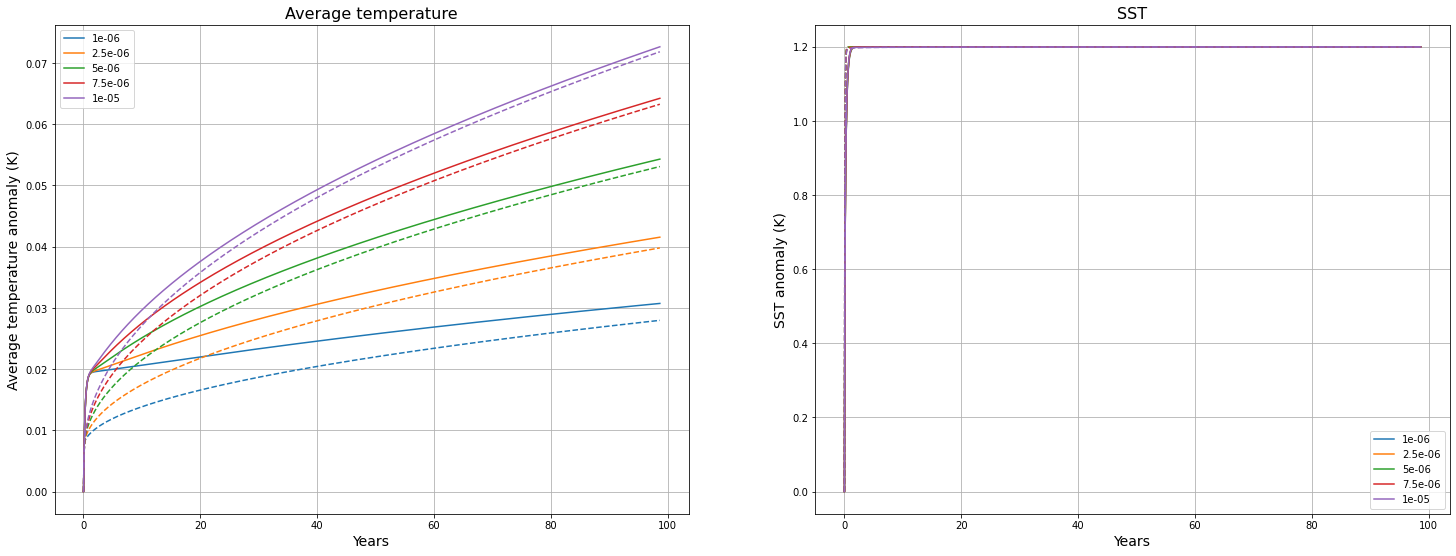

In [7]:
timesteps = cool_kappa.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

for k in range(0, len(kappas)):
    plot_cool, = axs[0].plot(time_years, - 1 * OHC((cool_kappa - control_kappa)[:, :, k]), label=f'{kappas[k]}')
    plot_warm = axs[0].plot(time_years, OHC((warm_kappa - control_kappa)[:, :, k]), color = plot_cool.get_color(), linestyle = '--')
    
    plot_cool, = axs[1].plot(time_years, - 1 * (cool_kappa - control_kappa)[0, :, k], label=f'{kappas[k]}')
    plot_warm = axs[1].plot(time_years, (warm_kappa - control_kappa)[0, :, k], color = plot_cool.get_color(), linestyle = '--')

axs[0].grid()
axs[0].set_title('Average temperature', fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

axs[1].grid()
axs[1].set_title('SST', fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()

#plt.savefig('temp_diagnostics.jpg')

print('I need a better way to plot all this. Need to think about it!')
print('CONCLUSION: The diffusivity is important for setting both the size of the average temperature response as well as how nonlinear it is. The difference between responses is smaller by the end of the simulation for higher diffusivities (i.e. less nonlinear), which makes sense as the warming information being integrated into the water column is completely dependent on diffusive processes, whereas the cooling depends on both diffusion and convection. The initial fast adjustment to the cooling is identical for all diffusivities, since again this initial response is dominated by convective sinking. Note here that the way the convection is paramaterised (mixing algorithm) is equivalent across the simulations. Convective parameterisations do indeed differ across ocean and climate models, and so this might change how nonlinear the responses are as well.')
plt.show()

# b) Changing z_m

In [8]:
### Run experiment

years = 100
days = dt / 86400
N = int(years * 360 / days)
M = int(z_b / dz)
t = np.linspace(0.0, years * 360, N + 1)

lambd = 8/(1.2 - 1.0)
mu = 1/(10 * 365 * 86400)
kappa = 5e-6

zms = np.arange(15, 60, 10)

Q_cont = np.append(0, np.zeros(int(years * 360 / days)))
T0_cont = np.append(0, np.zeros(int(years * 360 / days)))
Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

control_zm = np.zeros(shape = (M, N+1, zms.shape[0]))
cool_zm = np.zeros(shape = (M, N+1, zms.shape[0]))
warm_zm = np.zeros(shape = (M, N+1, zms.shape[0]))

for k in range(len(zms)):
    z_m = zms[k]
    gamma = lambd / (rho*c*z_m)
    T_i = initial_condition(z_t)
    control_zm[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_cont, T0_cont, years)
    cool_zm[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, - Q, - T0, years)
    warm_zm[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

I need a better way to plot all this. Need to think about it!
CONCLUSION: Increasing the minimum mixed layer depth tends to increase approximately linearly the average temperature response in the cooling and warming; it has very little response on the SST, since we showed that this is set solely by lambda, Q, and final SST anom


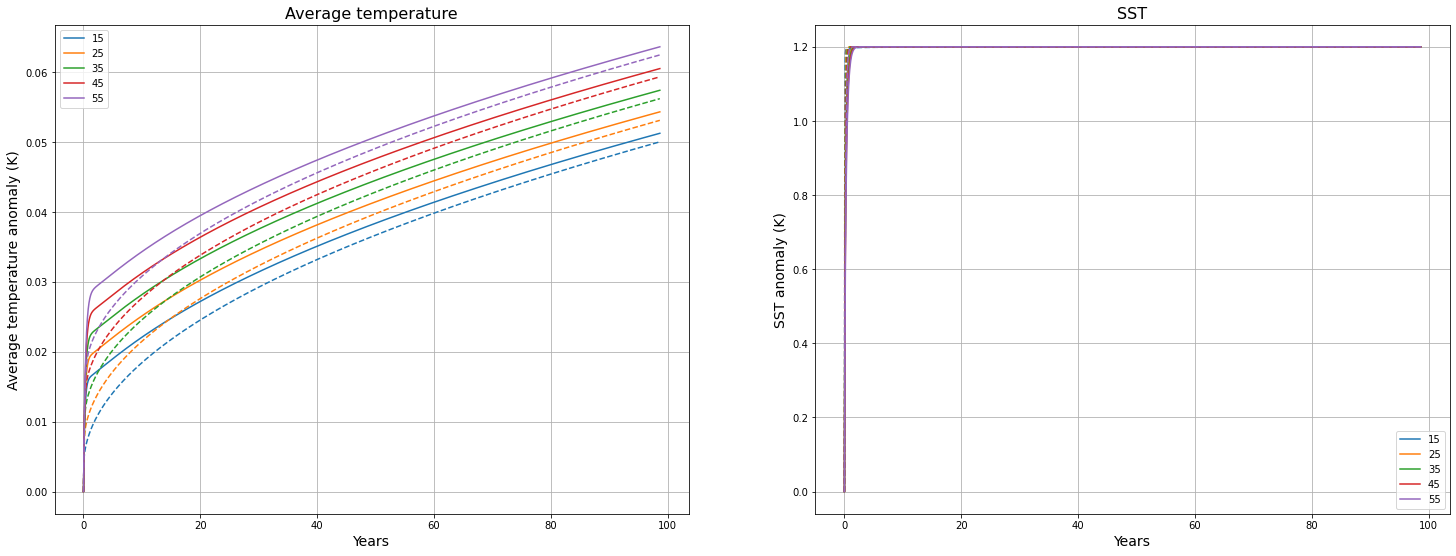

In [9]:
timesteps = cool_zm.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

for k in range(0, len(zms)):
    plot_cool, = axs[0].plot(time_years, - 1 * OHC((cool_zm - control_zm)[:, :, k]), label=f'{zms[k]}')
    plot_warm = axs[0].plot(time_years, OHC((warm_zm - control_zm)[:, :, k]), color = plot_cool.get_color(), linestyle = '--')
    
    plot_cool, = axs[1].plot(time_years, - 1 * (cool_zm - control_zm)[0, :, k], label=f'{zms[k]}')
    plot_warm = axs[1].plot(time_years, (warm_zm - control_zm)[0, :, k], color = plot_cool.get_color(), linestyle = '--')

axs[0].grid()
axs[0].set_title('Average temperature', fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

axs[1].grid()
axs[1].set_title('SST', fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()

#plt.savefig('temp_diagnostics.jpg')

print('I need a better way to plot all this. Need to think about it!')
print('CONCLUSION: Increasing the minimum mixed layer depth tends to increase approximately linearly the average temperature response in the cooling and warming; it has very little response on the SST, since we showed that this is set solely by lambda, Q, and final SST anom')
plt.show()

# c) Changing $\lambda$

In [10]:
### Run experiment

years = 100
days = dt / 86400
N = int(years * 360 / days)
M = int(z_b / dz)
t = np.linspace(0.0, years * 360, N + 1)

mu = 1/(10 * 365 * 86400)
kappa = 5e-6
z_m = 25
T_i = initial_condition(z_t)

gamma_days = np.array([30, 60, 90, 120, 150])#np.array([30, 80, 130, 180, 230]) #np.arange(30, 360, 80) # restoring timescale in inverse days
gammas = 1 / (gamma_days * 86400)

Q_cont = np.append(0, np.zeros(int(years * 360 / days)))
T0_cont = np.append(0, np.zeros(int(years * 360 / days)))
Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

control_gamma = np.zeros(shape = (M, N+1, gammas.shape[0]))
cool_gamma = np.zeros(shape = (M, N+1, gammas.shape[0]))
warm_gamma = np.zeros(shape = (M, N+1, gammas.shape[0]))

for k in range(len(gammas)):
    control_gamma[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gammas[k], T_i, Q_cont, T0_cont, years)
    cool_gamma[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gammas[k], T_i, - Q, - T0, years)
    warm_gamma[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gammas[k], T_i, Q, T0, years)

I need a better way to plot all this. Need to think about it!
CONCLUSION: The restoring has a very large effect on both averge temperature and SST. Need to make a note of why the cooling actually goes above the warming, an artefact of the model, not intended.


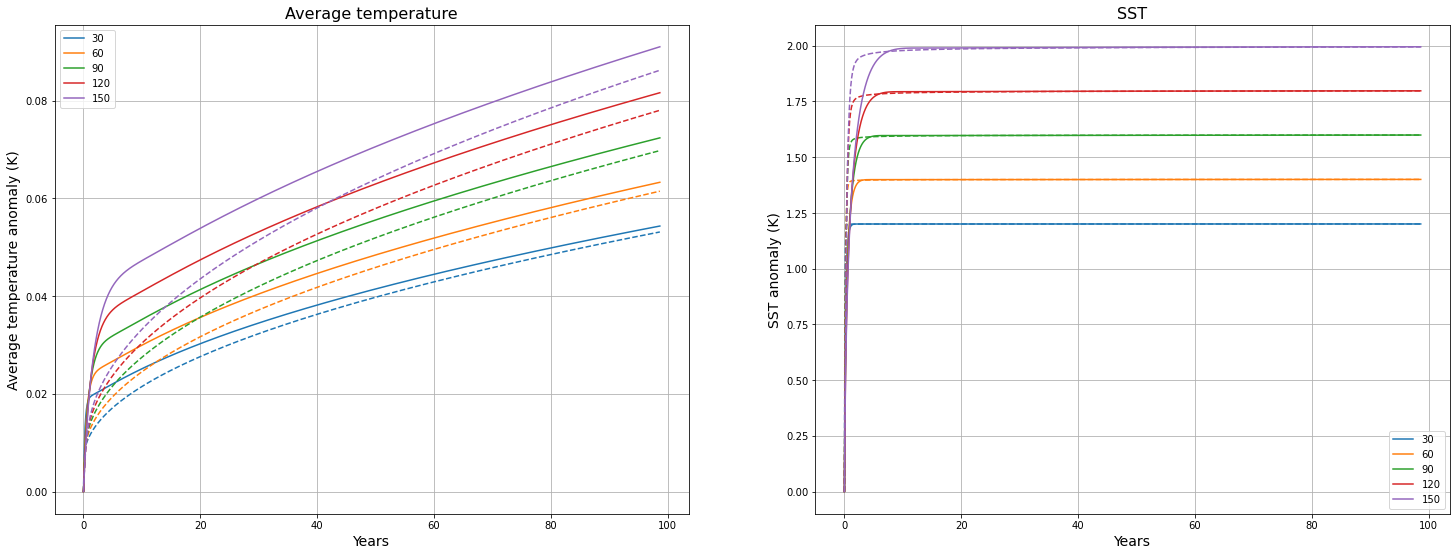

In [11]:
timesteps = cool_gamma.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

for k in range(0, len(gammas)):
    plot_cool, = axs[0].plot(time_years, - 1 * OHC((cool_gamma - control_gamma)[:, :, k]), label=f'{gamma_days[k]}')
    plot_warm = axs[0].plot(time_years, OHC((warm_gamma - control_gamma)[:, :, k]), color = plot_cool.get_color(), linestyle = '--')
    
    plot_cool, = axs[1].plot(time_years, - 1 * (cool_gamma - control_gamma)[0, :, k], label=f'{gamma_days[k]}')
    plot_warm = axs[1].plot(time_years, (warm_gamma - control_gamma)[0, :, k], color = plot_cool.get_color(), linestyle = '--')

axs[0].grid()
axs[0].set_title('Average temperature', fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

axs[1].grid()
axs[1].set_title('SST', fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()

#plt.savefig('temp_diagnostics.jpg')

print('I need a better way to plot all this. Need to think about it!')
print('CONCLUSION: The restoring has a very large effect on both averge temperature and SST. Need to make a note of why the cooling actually goes above the warming, an artefact of the model, not intended.')
plt.show()

# d) Changing stratification (i.e. top-bottom temperature gradient)

In [15]:
m = (27 - 5) / (25 - 1000)
m
np.arange(18, 27, 2)

array([18, 20, 22, 24, 26])

In [18]:
### Run experiment

years = 100
days = dt / 86400
N = int(years * 360 / days)
M = int(z_b / dz)
t = np.linspace(0.0, years * 360, N + 1)

kappa = 5e-6
z_m = 25
lambd = 8 / (1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
mu = 1 / (10 * 365 * 86400)

T_0s = np.arange(18, 27, 2)

Q_cont = np.append(0, np.zeros(int(years * 360 / days)))
T0_cont = np.append(0, np.zeros(int(years * 360 / days)))
Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

control_T0 = np.zeros(shape = (M, N+1, T_0s.shape[0]))
cool_T0 = np.zeros(shape = (M, N+1, T_0s.shape[0]))
warm_T0 = np.zeros(shape = (M, N+1, T_0s.shape[0]))

for k in range(len(T_0s)):
    
    T_0 = T_0s[k]
    T_i = initial_condition(z_t)
    
    control_T0[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_cont, T0_cont, years)
    cool_T0[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, - Q, - T0, years)
    warm_T0[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

In [ ]:
fig = plt.figure(figsize=(17,11))

timestep = -1
day = timestep * 10
depth_index = -1

for i in range(len(T0s)):
    plt.plot(control_T0[:depth_index, timestep, i], z_t[:depth_index], label=f'T_s = {int(T_0s[i])}$\degree$C', linestyle = '--')
plt.ylabel('Depth (m)', fontsize=12)
plt.xlabel('Temperature (deg C)', fontsize=12)
plt.title('Temperature profiles')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize=12)

I need a better way to plot all this. Need to think about it!
CONCLUSION: Weaker strartification --> larger asymmetry between cooling and warming in average temp, little change to SST


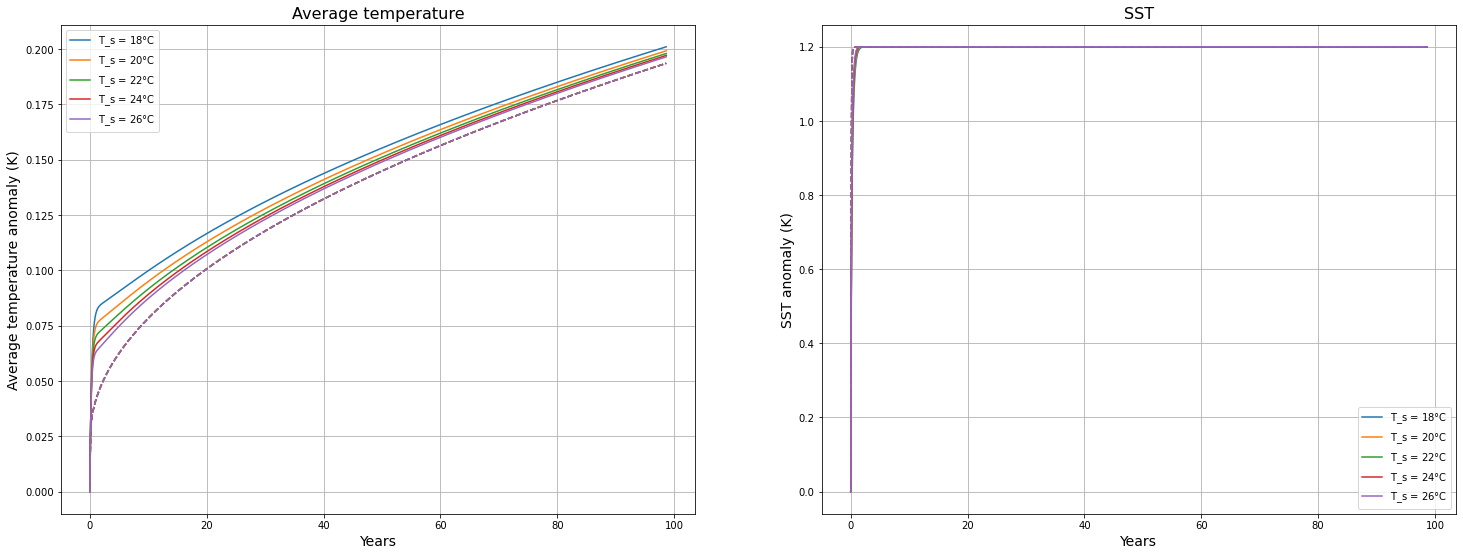

In [23]:
timesteps = cool_T0.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

for k in range(0, len(T_0s)):
    plot_cool, = axs[0].plot(time_years, - 1 * OHC((cool_T0 - control_T0)[:, :, k]), label=f'T_s = {T_0s[k]}$\degree$C')
    plot_warm = axs[0].plot(time_years, OHC((warm_T0 - control_T0)[:, :, k]), color = plot_cool.get_color(), linestyle = '--')
    
    plot_cool, = axs[1].plot(time_years, - 1 * (cool_T0 - control_T0)[0, :, k], label=f'T_s = {T_0s[k]}$\degree$C')
    plot_warm = axs[1].plot(time_years, (warm_T0 - control_T0)[0, :, k], color = plot_cool.get_color(), linestyle = '--')

axs[0].grid()
axs[0].set_title('Average temperature', fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

axs[1].grid()
axs[1].set_title('SST', fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()

#plt.savefig('temp_diagnostics.jpg')

print('I need a better way to plot all this. Need to think about it!')
print('CONCLUSION: Weaker strartification --> larger asymmetry between cooling and warming in average temp, little change to SST')
plt.show()

Text(0.5, 0, 'Years')

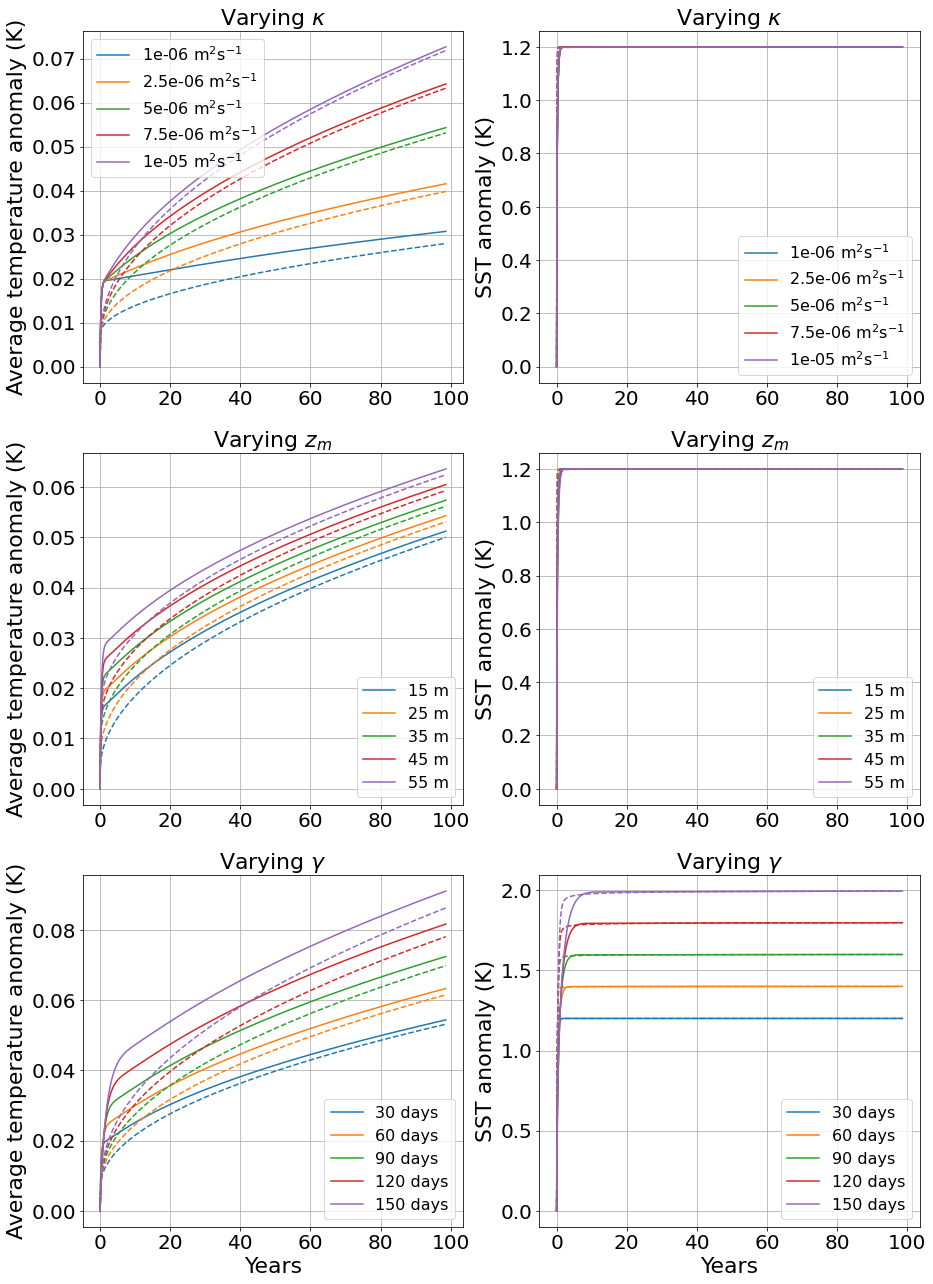

In [13]:
### Plot all on one figure

ncols = 2
nrows = 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (15,22))


def sensitivity_plot(params, units, param_name):
    for i in range(0, len(params)):
        plot_cool, = axs[row, 0].plot(time_years, - 1 * OHC((cool - control)[:, :, i]), label=f'{params[i]} %s' % (units))
        plot_warm = axs[row, 0].plot(time_years, OHC((warm - control)[:, :, i]), color = plot_cool.get_color(), linestyle = '--')
        
        plot_cool, = axs[row, 1].plot(time_years, - 1 * (cool - control)[0, :, i], label=f'{params[i]} %s' % (units))
        plot_warm = axs[row, 1].plot(time_years, (warm - control)[0, :, i], color = plot_cool.get_color(), linestyle = '--')
        
    axs[row, 0].grid()
    axs[row, 0].set_title('Varying %s' % (param_name), fontsize = 22)
    axs[row, 0].set_ylabel('Average temperature anomaly (K)', fontsize = 22)
    axs[row, 0].legend(fontsize = 16, loc='best')
    axs[row, 0].tick_params(labelsize =20)

    axs[row, 1].grid()
    axs[row, 1].set_title('Varying %s' % (param_name), fontsize = 22)
    axs[row, 1].set_ylabel('SST anomaly (K)', fontsize = 22)
    axs[row, 1].legend(fontsize = 16, loc='lower right')
    axs[row, 1].tick_params(labelsize = 20)

control = control_kappa
cool = cool_kappa
warm = warm_kappa
row = 0
sensitivity_plot(kappas, 'm$^2$s$^{-1}$', '$\kappa$')

control = control_zm
cool = cool_zm
warm = warm_zm
row = 1
sensitivity_plot(zms, 'm', '$z_m$')

control = control_gamma
cool = cool_gamma
warm = warm_gamma
row = 2
sensitivity_plot(gamma_days, 'days', '$\gamma$')

# control = control_T0
# cool = cool_T0
# warm = warm_T0
# row = 3
# sensitivity_plot(T_0s, '$\degree$C', '$T_s$')
    
axs[row, 0].set_xlabel('Years',fontsize = 22)
axs[row, 1].set_xlabel('Years',fontsize = 22)

plt.savefig('ch3_sensitivity_analysis.jpg', bbox_inches='tight', dpi=200)

## Sinusoidal with different kappa

In [13]:
years = 100
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

Q = 8.0
T0 = 1.0

### Run experiment

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho * c * z_m)
mu = 1/(5 * 365 * 86400)

kappas = np.arange(2.5e-6, 1.3e-5, 2.5e-6)

Q_cont = np.append(0, np.zeros(int(years * 360 / days)))
T0_cont = np.append(0, np.zeros(int(years * 360 / days)))
Q = sin(Q, 7)
T0 = sin(T0, 7)

control_kappa = np.zeros(shape = (M, N+1, kappas.shape[0]))
sinusoidal_kappa = np.zeros(shape = (M, N+1, kappas.shape[0]))

for k in range(len(kappas)):
    control_kappa[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, T_i, Q_cont, T0_cont, years)
    sinusoidal_kappa[:, :, k] = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, T_i, Q, T0, years)

CPU times: user 27.5 s, sys: 9.83 ms, total: 27.6 s
Wall time: 27.6 s


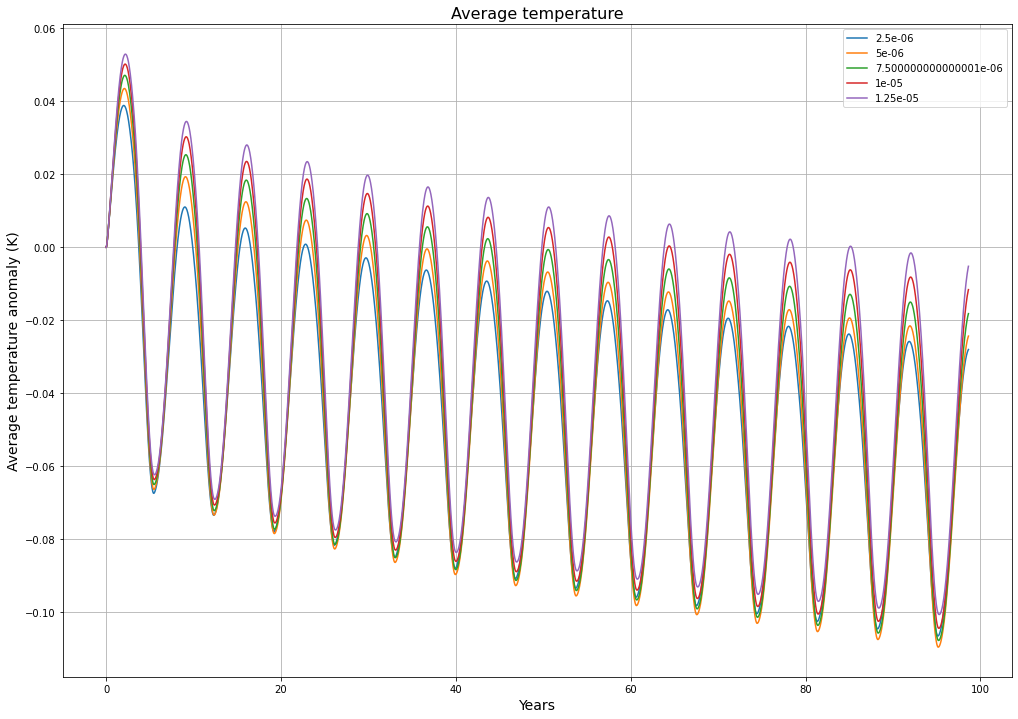

In [9]:
timesteps = cool_kappa.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

plt.figure(figsize=(17,12))

for k in range(0, len(kappas)):
    plt.plot(time_years, OHC((warm_kappa - control_kappa)[:, :, k]), label=f'{kappas[k]}')

plt.grid()
plt.title('Depth-average temperature', fontsize = 16)
plt.ylabel('Temperature anomaly (K)', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.legend()

#plt.savefig('temp_diagnostics.jpg')

# print('I need a better way to plot all this. Need to think about it!')
# print('CONCLUSION: The diffusivity is important for setting both the size of the average temperature response as well as how nonlinear it is. The difference between responses is smaller by the end of the simulation for higher diffusivities (i.e. less nonlinear), which makes sense as the warming information being integrated into the water column is completely dependent on diffusive processes, whereas the cooling depends on both diffusion and convection. The initial fast adjustment to the cooling is identical for all diffusivities, since again this initial response is dominated by convective sinking. Note here that the way the convection is paramaterised (mixing algorithm) is equivalent across the simulations. Convective parameterisations do indeed differ across ocean and climate models, and so this might change how nonlinear the responses are as well.')
plt.show()